#Notebook de pre-procesamiento

##Pre-requisitos

In [ ]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 
!pip install tensorflow-io

     |████████████████████████████████| 35.5MB 1.3MB/s 
     |████████████████████████████████| 21.8MB 1.3MB/s 


In [ ]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 
import gc
import tensorflow as tf
import tensorflow_io as tfio
from PIL import Image, ImageOps

##Conexión a Drive

In [ ]:
#CONEXIÓN DRIVE 
from google.colab import drive

drive.mount('/content/drive')

# Root directory of the project 
ROOT_DIR = os.path.abspath('/content/RN__TP_Final')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Marco Teórico

##Diagnóstico clínico de opacidad en radiografía de torax



###Radiografía

Una radiografía es una imagen que se obtiene al exponer al paciente a una fuente de radiación de alta energía, comúnmente rayos X o radiación gamma procedente de isótopos radiactivos (iridio-192, cobalto-60, cesio-137, entre otros). Al interponer un objeto entre la fuente de radiación y el receptor, las partes más densas aparecen con diferentes tonos dentro de una escala de grises. En particular, las radiografías por rayos X usan una dosis muy pequeña de radiación ionizante para producir imágenes de las estructuras internas del cuerpo. Las radiografías son la forma más antigua y más utilizada de imágenes médicas. Si bien se utilizan en varios rubros y con distintos fines, en el área médica la técnica produce imágenes bidimensionales de alta resolución y proporciona un medio rápido y de bajo costo para ayudar a diagnosticar fracturas de huesos, buscar lesiones o infecciones y localizar objetos extraños en los tejidos blandos. Algunos exámenes de rayos X pueden usar un material de contraste a base de yodo o bario para ayudar a mejorar la visibilidad de órganos, vasos sanguíneos, tejidos o huesos específicos.

Con respecto a los artefactos, los mismos pueden presentarse de varias maneras. Los artefactos son las sombras anormales observadas en una radiografía, con implicancias en la calidad de imagen, y dicho deterioro se ha producido por medios artificiales a partir de fallas de hardware, errores del operador y artefactos de software (postprocesamiento). Entre las causas comunes se encuentra el manejo inadecuado de las películas, los errores al procesar las películas y el movimiento del paciente mientras toma la imagen. Los artefactos comunes a todas las formas de radiografía son:
- Artefacto de movimiento: se forma por el movimiento del paciente, resultando en una imagen distorsionada.
- Composición de imagenes: superposición de dos estructuras desde diferentes ubicaciones debido a la doble exposición de la misma película 
- Problemas de desarrollo: Puede ocurrir que partes de la imagen radiográfica haya sido golpeada por la luz después de que la película fue expuesta a rayos X. Esto generalmente ocurre cuando la película ingresa al procesador automático y alguien enciende accidentalmente las luces o abre la puerta del cuarto oscuro demasiado pronto. También puede ocurrir que un tiempo insuficiente entre la alimentación de la película a través del procesador automático produzca que haya un área oscura superpuestas en el procedimiento de desarrollo. 
- Problemas ambientales: objetos comunes, como trozos de papel, pueden causar un artefacto radioopaco [3] [4]




###Opacidad pulmonar en radiografía X

La opacidad en un estudio de radiografía es un término bastante laxo. Puede referirse a cualquier área que atenúa preferentemente el haz de rayos X y, por lo tanto, aparece más clara (radio-opaca) que el área circundante. Es un término inespecífico que no indica el tamaño o la naturaleza patológica de la anormalidad. Las figuras a continuación se incluyen para destacar la diferencia entre un pulmón normal y un pulmón que presenta opacidad, ya que se pueden ver sombras blancas (opacidades) en el límite inferior de los pulmones de la primer figura. En la segunda imagen, los pulmones normales al estar compuestos en gran proporción por aire se ven mayoritariamente negros y no poseen sombras blancas en su porción inferior.

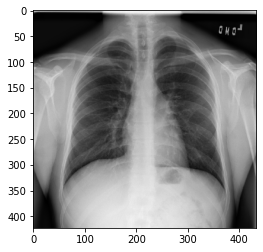

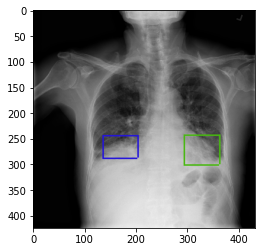

In [ ]:
img_dir = '/content/drive/My Drive/Final_redes/pulmonNormal.PNG'
img_dir1 = '/content/drive/My Drive/Final_redes/pulmonOpacidad.PNG'

img = np.array(Image.open(img_dir))
img1 = np.array(Image.open(img_dir1))
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(img1)

La detección de opacidades se encuentra relacionada a la presencia de neumonía. Por lo general, los pulmones están llenos de aire. Cuando alguien tiene neumonía, el aire en los pulmones se reemplaza parcialmente por otro material: fluidos, bacterias, células del sistema inmunitario, etc. Es por eso que las áreas de opacidad son áreas que son grises pero deberían ser más negras. Cuando los vemos entendemos que el tejido pulmonar en esa área probablemente no es fisiológicamente saludable. 

Una de las dificultades asociadas a la detección de opacidades es que las mismas no son homogéneas y por lo tanto, no tienen un centro o límites claros. Esto lleva a una gran variabilidad conocida entre los radiólogos en la interpretación de las radiografías de tórax. A su vez, teniendo en cuenta la amplia definición de opacidades, hay diferentes tipos y no todas se encuentran relacionadas con la neumonía. Los nódulos y masas pulmonares se definen como "una opacidad redondeada, bien o mal definida" [5]. La diferencia entre un nódulo y una masa es el tamaño de la opacidad. En muchos casos, la presencia de múltiples nódulos y masas se encuentran asociados a un cáncer invasivo y no necesariamente a una neumonía. Por lo tanto, la detección de opacidades esta ligada a múltiples causas, y la correcta detección de dichas opacidades asociadas a probables neumonías es de vital importancia para evitar confusiones con otras enfermedades. 

##Neumonía asociada a opacidades en el pulmón
La neumonía es una infección pulmonar que puede ser causada por bacterias, virus u hongos. Debido a la infección y a la correspondiente respuesta inmune del cuerpo, los sacos en los pulmones (denominados alvéolos) están llenos de líquidos en lugar de aire. La razón por la cual las opacidades pulmonares asociadas a la neumonía se ven difusas en la radiografía de tórax es porque la infección y el líquido que se acumula se propagan dentro del árbol normal de las vías respiratorias en el pulmón. No hay un borde claro donde se detiene la infección. Eso es diferente de otras enfermedades como los tumores, que son totalmente diferentes del pulmón normal y no mantienen la estructura normal de las vías respiratorias dentro del pulmón. Es por esto que las radiografías de tórax cambian cuando una persona tiene neumonía, y por lo tanto, se utilizan como herramienta de diagnóstico en la detección de la enfermedad. 

##Desafíos clínicos
A su vez, un gran desafío en la detección de neumonía únicamente a partir de radiografías es que en la práctica dicha enfermedad se diagnostica no solo a partir de una imagen radiográfica ya que se debe incluir al paciente y a su historia clínica correspondiente. Por lo tanto, pueden haber imágenes que se asemejan a una neumonía pero que un médico es capaz de descartar a partir del resto del contexto. Esto se tuvo en cuenta a la hora de brindar las instrucciones para armar el dataset correspondiente (las mismas se encuentran desarrolladas a continuación).

A su vez, el problema de detección en cuestión se conceptualiza a partir de una necesidad de una herramienta de asistencia para el diagnóstico. Por lo tanto, es importante que el modelo elegido sea capaz de arribar a un resultado en tiempo real. No solo eso, en un contexto hospitalario donde se realizan centenas de estudios radiológicos de esta naturaleza por semana, se presenta la dificultad de que la gran mayoría de estas imágenes se archivan sin un informe de un radiólogo. Por lo general, son ordenadas y estudiadas por médicos de guardia que suelen ser residentes con pocos años de experiencia. Un asistente de esta naturaleza podría ayudar a orientar el diagnóstico de estos médicos.

# Dataset

*RSNA Pneumonia Detection Challenge*

La Sociedad Radiológica de América del Norte (RSNA) decidió apelar a la comunidad de desarrolladores de la plataforma de competencias Kaggle a mediados del 2018 para la detección de neumonía en imágenes de radiografía de tórax (CXR). En colaboración con los Institutos Nacionales de la Salud (NIH), la Sociedad de Radiología Torácica y MD.ai, armaron un dataset basto y etiquetado de CXR enfocado a la detección de opacidades en los pulmones vinculadas al diagnóstico de neumonía. Con un total de U$\$$S 30.000 de recompensa para las mejores resoluciones del problema, publicaron esta competencia con la esperanza de que la inteligencia artificial demuestre ser una buena herramienta para sortear los desafíos implicados [6]. 


El *dataset* propuesto por RSNA consiste de 30.000 exámenes radiológicos. Éstos fueron tomados de un conjunto de datos de 112.000 imágenes de radiología frontal de tórax publicado en el 2017 por NIH. Este dataset original contiene imágenes clasificadas en 14 patologías torácicas a partir de un procesamiento automatizado de sus informes de radiología. 

El hecho de que NIH haya optado por un procesamiento automatizado del texto que compone a estos informes permitió el amplio volumen de imágenes procesadas pero no debe desestimarse la diferencia entre la etiqueta que otorgaría un profesional de la salud al leer un informe que la que puede escoger un procesador. Es por esto que se pueden identificar errores en el otorgamiento de etiquetas. RSNA seleccionó 30.000 de estos exámenes, los cuales estaban compuestos por:

- 15.000 exámenes que tengan una de las tres etiquetas relacionadas a neumonía *Neumonía*, *Infiltración* y *Consolidación*)
- 7.500 exámenes con la etiqueta de *Sin hallazgos*
- 7.500 exámenes con otras etiquetas, correspondientes a patologías torácicas que no pueden relacionarse con neumonía


Se generaron identificadores aleatorios para cada uno de los 30.000 exámenes. RSNA convocó a un equipo de seis radiólogos que contaban con muchos años de experiencia en las mejores instituciones académicas. Al momento de etiquetar las imágenes, se les dio las siguientes instrucciones:

- Identificar opacidad pulmonar mediante un cuadro delimitador. Esto se debe a que un hallazgo en la radiografía de tórax de un paciente con tos y fiebre tiene una alta probabilidad de ser neumonía
- Entendiendo que en ausencia de información clínica, radiografía lateral y exámenes seriados, se espera hacer suposiciones
- Incluir cualquier área que sea más opaca que el área circundante (definición de Fleischner)
- Excluir: masa (s) obvia (s), nódulo (s), colapso lobular, atelectasia lineal 

En los casos etiquetados como *No Normal / Sin Opacidad Pulmonar*, *Sin Opacidad Pulmonar* se refiere a ninguna opacidad que pueda ser relacionada con neumonía. Otras opacidades no neumónicas pueden estar presentes. Además, algunos de los casos no normales tienen anomalías sutiles que requieren un ojo entrenado para discernir su procedencia. (Lo que, por ahora, mantiene a los radiólogos cerca). 

En los casos donde los radiólogos no coincidían en la etiqueta de la imagen, se buscaba promediar las posibles discrepancias para obtener un único resultado. Para las etiquetas débiles, se utilizó el voto mayoritario.  Los 3.000 casos restantes de triple lectura comprendieron el conjunto de prueba [7].

Debido a la pandemia de COVID-19, la competencia terminada en noviembre del 2018 volvió a cobrar importancia. Los coordinadores de la competencia han publicado en mayo del presente año un refinamiento de los datos. Se informa el likelihood de las etiquetas asignadas a los datos originales, es decir de que la opacidad anotada sea neumonía, con la esperanza de que pueda ayudar a desarrollar modelos para la detección del virus mediante procesamiento de CXR.



## Kaggle

Esta celda se corrió solo la primera vez para descargarnos los datasets de Kaggle. Una vez descargados a drive solo se debe correr la celda de conexión al drive para acceder a los mismos.  

In [ ]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

!pip install --upgrade kaggle --force-reinstall --no-deps kaggle

# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="valemosquera"
os.environ['KAGGLE_KEY']="4d7cf6400a49f7943d1c795eabb41282" 

# Root directory of the project
ROOT_DIR = os.path.abspath('/content/RN__TP_Final')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

# If you are unable to download the competition dataset, check to see if you have 
# accepted the user agreement on the competition website. 
!kaggle competitions download -c rsna-pneumonia-detection-challenge

     |████████████████████████████████| 61kB 1.8MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=7ec076e9a7962376c2849cad4431242d05c4a50d5bec6d16530764f1ad7b5f2f
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
100% 3.65G/3.66G [00:54<00:00, 107MB/s] 
100% 3.66G/3.66G [00:54<00:00, 72.2MB/s]
unzip:  cannot find or open stage_2_test_images.zip, stage_2_test_images.zip.zip or stage_2_test_images.zip.ZIP.
unzip:  cannot find or open stage_2_train_images.zip, stage_2_train_images.zip.zip or stage_2_train_images.zip.ZIP.
unzip:  cannot find or open stage_2_train_labels.csv.zip, stage_2_train_labels.csv.zip.zip or stage_2_train_labels.csv.zip.ZIP.


In [ ]:
#Unzip the content into the colab project
!unzip rsna-pneumonia-detection-challenge.zip

In [ ]:
#Move content from colab project location to google drive indicated folder
#The content is moved as a folder
!mv /content/RN__TP_Final '/content/drive/My Drive/Final_redes'

## Exploratory Data Analysis

Los datos se encuentran en formato DICOM. Se asume que hay un único archivo DICOM por cada paciente, por lo que se lo identifica con un id bajo la leyenda *patientId*. Las etiquetas se encuentran en formato .csv bajo 7 columnas:

- *patientId*: Identificador único de un estudio de un paciente dado (una imagen).
- *class*: Etiqueta asignada por el equipo de profesionales. Como indicado previamente, las tres categorías son *No Lung Opacity / Not Normal*,* Lung Opacity* y *Normal*
- *x*: Coordenada horizontal de la esquina superior izquierda de la opacidad en la imagen
- *y*: Coordenada vertical de la esquina superior izquierda de la opacidad en la imagen
- *width*: Ancho de la opacidad en la imagen (a partir de x)
- *height*: Altura de la opacidad en la imagen (a partir de y)
- *Target*: Discriminador indicando si se identificó al menos una opacidad relacionada a neumonía (true: 1) o no (false: 0). 

In [ ]:
#Build directions
main_dir = '/content/drive/My Drive/Final_redes/RN__TP_Final'
train_dicom_dir = os.path.join(main_dir, 'stage_2_train_images')
test_dicom_dir = os.path.join(main_dir, 'stage_2_test_images')
train_labels_dir = os.path.join(main_dir, 'stage_2_train_labels.csv')

In [ ]:
#Labels are not longer a class: given a patient id, one or more rows with bounding box coordinates.
#If no bounding box, row with id but empty coordinates
annotations = pd.read_csv(os.path.join(main_dir, 'stage_2_train_labels.csv'))
annotations.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
detailed_class_info = pd.read_csv(os.path.join(main_dir, 'stage_2_detailed_class_info.csv'))
train_labels = pd.read_csv(train_labels_dir) 

df = pd.merge(left = detailed_class_info, right = train_labels, how = 'left', on = 'patientId')

del detailed_class_info, train_labels
gc.collect()

df.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37629 entries, 0 to 37628
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  37629 non-null  object 
 1   class      37629 non-null  object 
 2   x          16957 non-null  float64
 3   y          16957 non-null  float64
 4   width      16957 non-null  float64
 5   height     16957 non-null  float64
 6   Target     37629 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.3+ MB


El número de etiquetas de cada paciente depende del número de opacidades que se encuentren en la CXR. Si no se ha identificado ninguna opacidad en el estudio radiológico del paciente, habrá una etiqueta con el id correspondiente a ese estudio pero con el resto de las propiedades vacías. Si en una imagen de radiografía se identifica al menos una opacidad, habrá una etiqueta por cada opacidad identificada y todas las etiquetas que corresponden a la misma radiografía tendrán el mismo *patientId*. Es importante aclarar que las entradas de un mismo estudio radiológico tendrán siempre la misma clase, sin excepción.

##Train

El dataset consta de 26.684 imágenes. Esto se refleja en 37.629 etiquetas. Sin embargo, hay muchas etiquetas duplicadas. Al retirarlas, el número de entradas se reduce a 30.227. 

In [ ]:
#Duplicated rows of bounding boxes
df.head(20)

,patientId,class,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
6,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1
7,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,562.0,152.0,256.0,453.0,1
8,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0


In [ ]:
df = df.drop_duplicates()
df.info()

#After dropping duplicates, only 30227 entries from the original 37629 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   class      30227 non-null  object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
#Grouping by patient id, in descending order. The maximum number of bounding boxes in the dataset is 4
df['patientId'].value_counts().head(50)

0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d    4
32408669-c137-4e8d-bd62-fe8345b40e73    4
ee820aa5-4804-4984-97b3-f0a71d69702f    4
8dc8e54b-5b05-4dac-80b9-fa48878621e2    4
7d674c82-5501-4730-92c5-d241fd6911e7    4
1c44e0a4-4612-438f-9a83-8d5bf919cb67    4
349f10b4-dc3e-4f3f-b2e4-a5b81448ce87    4
0ab261f9-4eb5-42ab-a9a5-e918904d6356    4
3239951b-6211-4290-b237-3d9ad17176db    4
76f71a93-8105-4c79-a010-0cfa86f0061a    4
31764d54-ea3b-434f-bae2-8c579ed13799    4
1bf08f3b-a273-4f51-bafa-b55ada2c23b5    4
0d5bc737-03de-4bb8-98a1-45b7180c3e0f    4
f4362a52-b9f5-4d96-a6ba-04284a233eb0    3
f9230537-bb87-4de7-90f1-73bc730d4b3b    3
1d57c801-71b4-49da-8933-2cabdc927fef    3
0afeabf5-d5a3-454f-a50d-887f0d21106c    3
2cd0cbc4-bf35-49de-963e-8ee3fd08ca75    3
e6a3f420-39d4-4042-8485-87024e7fb4f3    3
0b2057bc-4c6d-4c90-8975-94c02392e460    3
2e4b20f7-69c4-4680-9c8b-6984c195b1cf    3
aac8b420-f849-4c60-8486-0155f282633b    3
b2314db2-44f7-4fea-9a4a-a0d22f518ac6    3
098e14d4-3205-4c2d-a059-738f830c0a

Se analiza la cantidad de opacidades detectadas. Se concluye que hay 23286 etiquetas con una bounding box, 3266 con dos, 119 con tres y 13 con cuatro. Hay un total de 26.684 etiquetas con al menos una bounding box.

In [ ]:
#Grouping by groups of number of bounding boxes
df['patientId'].value_counts().value_counts()
#Patients with 1 row include both no bounding box and only one bounding box

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64

In [ ]:
df[df['Target'] == 0]['patientId'].value_counts().value_counts()
# 68,38% dont have a bounding box 
# 8,65% have 1 bounding box
# 10,8% have 2 bounding boxes
# 0,39% have 3 bounding boxes
# 0,04% have 4 bounding boxes

1    20672
Name: patientId, dtype: int64

En las figuras a continuación, se muestra la distribución de estas entradas según la clase asignada por el equipo de radiólogos y según el número de opacidades identificadas en el estudio radiológico.

<BarContainer object of 3 artists>

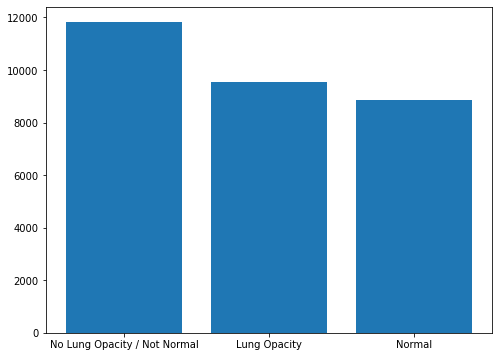

In [ ]:
plt.figure(figsize=(8,6))
plt.bar(['No Lung Opacity / Not Normal','Lung Opacity','Normal'],df["class"].value_counts())

<BarContainer object of 5 artists>

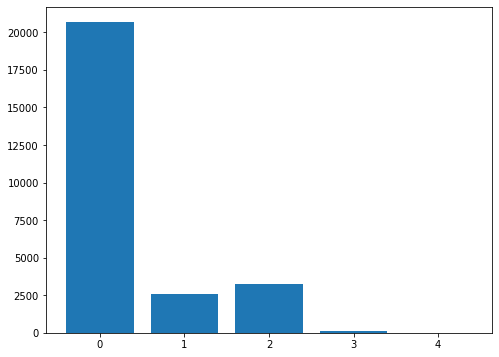

In [ ]:
plt.figure(figsize=(8,6))
plt.bar([0,1,2,3,4],[20672,23286-20672,3266,119,13])

In [ ]:
df_areas = df.dropna()[['x', 'y', 'width', 'height']].copy()
df_areas['x_2'] = df_areas['x'] + df_areas['width']
df_areas['y_2'] = df_areas['y'] + df_areas['height']
df_areas['x_center'] = df_areas['x'] + df_areas['width'] / 2
df_areas['y_center'] = df_areas['y'] + df_areas['height'] / 2
df_areas['area'] = df_areas['width'] * df_areas['height']

df_areas.head()

,x,y,width,height,x_2,y_2,x_center,y_center,area
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
10,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
11,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
18,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


El uso del formato DICOM para guardar estudios clínicos está muy divulgado en la comunidad médica ya que permite no sólo guardar el resultado del estudio sino que también guardar junto con él información sobre el contexto de este estudio: datos del paciente, datos del operario, datos del establecimiento sanitario, datos sobre cómo se tomaron las imágenes, etc. 

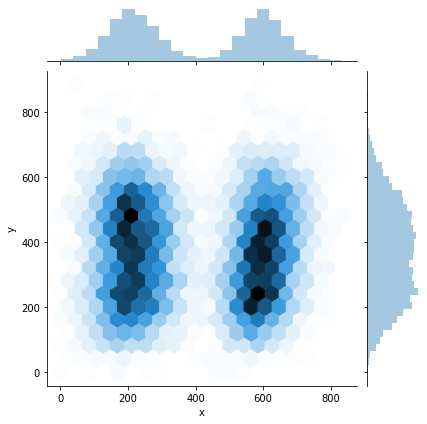

In [ ]:
#Statistic position of x and y coordinates: upper-left corner
sns.jointplot(x = 'x', y = 'y', data = df_areas, kind = 'hex', gridsize = 20);

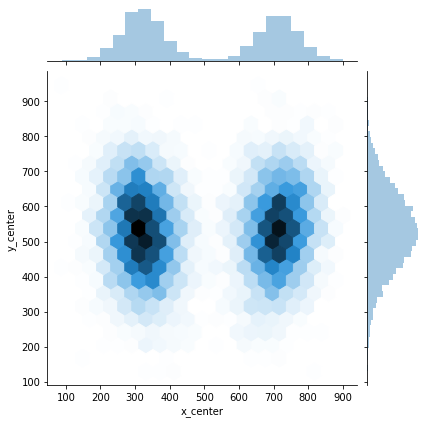

In [ ]:
#Statistic position of x_center and y_center coordinates
sns.jointplot(x = 'x_center', y = 'y_center', data = df_areas, kind = 'hex', gridsize = 20);

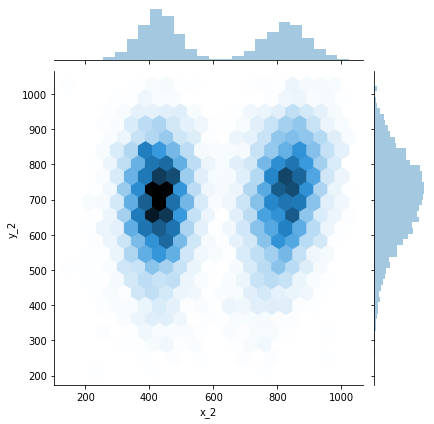

In [ ]:
#Statistic position of x_2 and y_2 coordinates: lower-right corner
sns.jointplot(x = 'x_2', y = 'y_2', data = df_areas, kind = 'hex', gridsize = 20);

A continuación se presentan varias figuras con el resultado de registrar la combinación de altura y ancho de cada bounding box contenedora de una opacidad del subset de train. La correlación entre ambas resulta evidente ya que aumentan de forma notablemente proporcional.

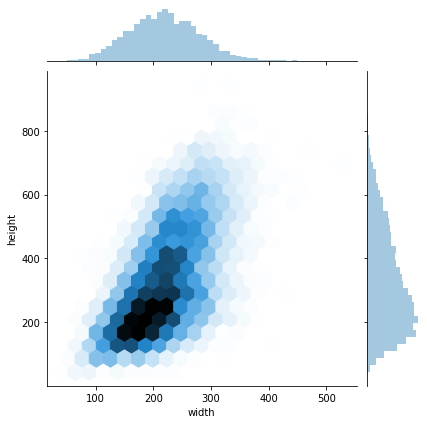

In [ ]:
#Statistic distribution of height and width -> high correlation
sns.jointplot(x = 'width', y = 'height', data = df_areas, kind = 'hex', gridsize = 20);

A continuación se hizo un breve análisis estadístico para visualizar la diistribución de las etiquetas relacionadas con los valores de x, y, width y height. Se presenta la información en gráficos de caja.

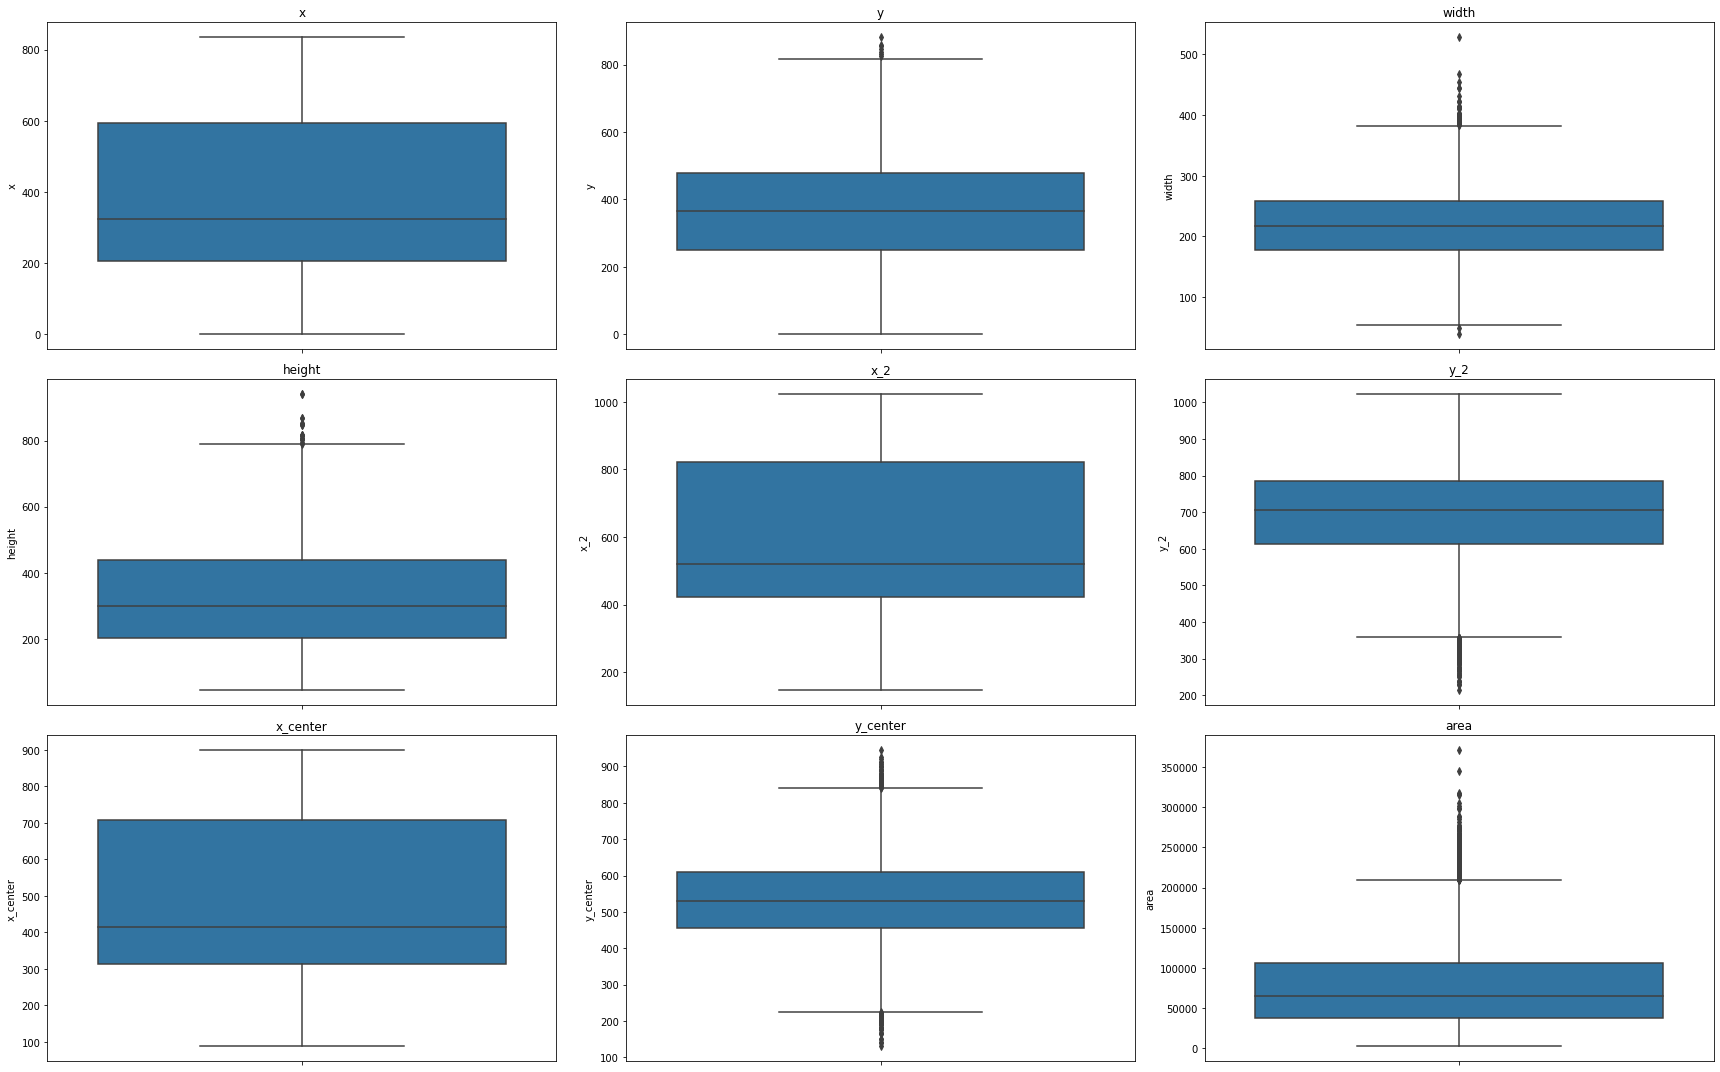

In [ ]:
n_columns = 3
n_rows = 3
_, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 5 * n_rows))
for i, c in enumerate(df_areas.columns):
    sns.boxplot(y = c, data = df_areas, ax = axes[i // n_columns, i % n_columns]).set_title(df_areas.columns[i])
plt.tight_layout()
plt.show()

A continuación se muestra un gráfico de calor que resulta de sumar las bounding boxes de las entradas del subset de train. Cuantos más valores se registren para un par coordenado, más claro se representa el color del píxel en el gráfico. 

Como es esperable, las dos formas que se destacan se asemejan a la forma y posición de los pulmones en una imagen de radiografía torácica frontal. A pesar de que esta conclusión parece obvia, nos permite concluir que sería oportuno utilizar una función de costo que explote esta ubicación espacial. 

In [ ]:
heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for index, row in df[df['Target'] == 1].iterrows():
  x_i = int(row[2])
  y_i = int(row[3])
  width_i = int(row[4])
  height_i = int(row[5])
  heatmap[y_i:y_i+height_i, x_i:x_i+width_i] += 1
  ws.append(width_i)
  hs.append(height_i)

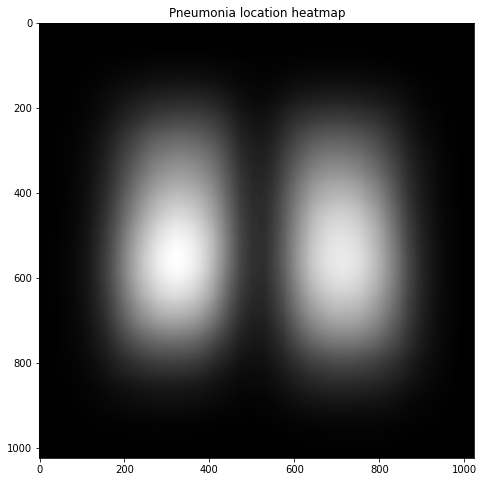

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap, cmap='gray')

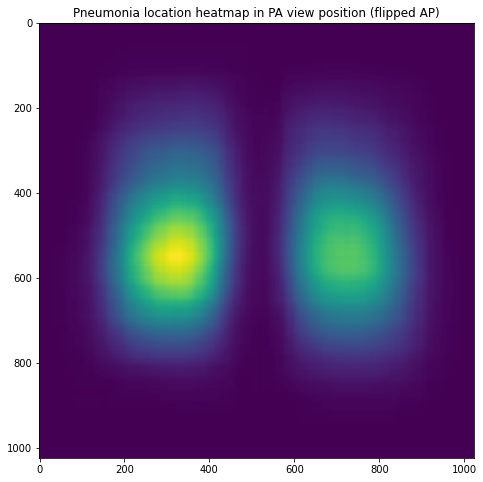

In [ ]:
heatmap2 = np.zeros((1024, 1024))
ws2 = []
hs2 = []
for index, row in df[df['Target'] == 1].iterrows():
  x_i = int(row[2])
  y_i = int(row[3])
  width_i = int(row[4])
  height_i = int(row[5])
  if (row['ViewPosition']=='PA'):
    heatmap2[y_i:y_i+height_i, x_i:x_i+width_i] += 1
  
  if (row['ViewPosition']=='AP'):
    heatmap2[y_i:y_i+height_i, (1024-x_i):1024-(x_i+width_i)] += 1

  ws2.append(width_i)
  hs2.append(height_i)

plt.figure(figsize=(8,8))
plt.title('Pneumonia location heatmap in PA view position (flipped AP)')
plt.imshow(heatmap2)

In [ ]:
#Entries with opacity -> not grouped, more than one per patient
#df_with_op = df[df['Target'] == 1]
#df_with_op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 37626
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  9555 non-null   object 
 1   class      9555 non-null   object 
 2   x          9555 non-null   float64
 3   y          9555 non-null   float64
 4   width      9555 non-null   float64
 5   height     9555 non-null   float64
 6   Target     9555 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 597.2+ KB


In [ ]:
#Group by patient id, images with more than one opacity to check whether or not bounding box overlap
#patients_with_ops = df_with_op[df_with_op['patientId'].isin(df_with_op['patientId'].value_counts()[df_with_op['patientId'].value_counts() != 1].index)].patientId.unique()
#print('There are',len(patients_with_ops),'patients with more than one opacity')
#patients_with_ops

There are 3398 patients with more than one opacity


array(['00436515-870c-4b36-a041-de91049b9ab4',
       '00704310-78a8-4b38-8475-49f4573b2dbb',
       '00aecb01-a116-45a2-956c-08d2fa55433f', ...,
       'c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2',
       'c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8',
       'c1f7889a-9ea9-4acb-b64c-b737c929599a'], dtype=object)

### Taking into account view position

Ésta es una de las grandes lecciones que tuvimos a la hora de analizar el dataset. Una de las propiedades de los archivos DICOM del dataset es View Position, la cual aporta información sobre cómo estaba posicionado el paciente al momento de realizar el estudio. Puede tomar el valor AP significando anteroposterior o PA por posteroanterior. En este dataset de 30.227 etiquetas, 14.930 fueron tomados con el paciente en una posición posteroanterior al equipo mientras que 15.297 en posición anteroposterior. 

Originalmente, leyendo la bibliografía relacionada a las radiografías de tórax interpretamos que si la radiografía se había tomado con el paciente en posición anteroposterior (AP) o posteroanterior (PA), el corazón debía estar en lados distintos de la imagen. Sin embargo, esto no es así. Sin importar en qué posición se encuentra el paciente, la imagen luego es presentada con el corazón del lado derecho de la imagen.

El pulmón izquierdo es de un tamaño anatómicamente menor debido a esto, lo cual debería ser tenido en cuenta al momento de entrenar la red. Dado que la posición posteroanterior es la recomendada, decidimos espejar los estudios tomados anteroposteriormente. Presentamos el código que utilizamos para espejar las imágenes según su ViewPosition. Fue parte del proceso del trabajo final que estamos entregando. Realizamos un dataset separado con esta característica y comenzamos a entrenar una red con este dataset que luego descartamos, como se comentará en la notebook de Desarrollo.



In [ ]:
attributes = ['PatientSex', 'PatientAge', 'ViewPosition']
for a in attributes:
    df[a] = df['patientId'].apply(lambda x: get_metadata_per_patient(x, a))
df.head()

In [ ]:
print(len(df[df['ViewPosition']=='PA']),'of the images were taken with the patient in a PA view position and ',len(df[df['ViewPosition']=='AP']),' were taken in AP view position')

14930 of the images were taken with the patient in a PA view position and  15297  were taken in AP view position


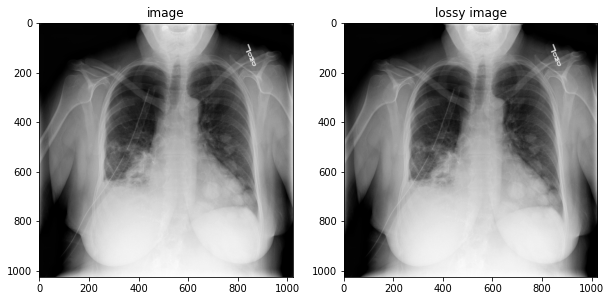

In [ ]:
image_bytes = tf.io.read_file(os.path.join(train_dicom_dir,'0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm'))

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

In [ ]:
def get_dcm_data_per_patient(pId):
    '''
    Given one patient ID, 
    return the corresponding dicom data.
    '''
    return pydicom.read_file(os.path.join(train_dicom_dir,pId+'.dcm'))

def get_metadata_per_patient(pId, attribute):
    '''
    Given a patient ID, return useful meta-data from the corresponding dicom image header.
    Return: 
    attribute value
    '''
    # get dicom image
    dcmdata = get_dcm_data_per_patient(pId)
    # extract attribute values
    attribute_value = getattr(dcmdata, attribute)
    return attribute_value

In [ ]:
df['ViewPosition'] = df['patientId'].apply(lambda x: get_metadata_per_patient(x, 'ViewPosition'))
df.head()

,patientId,class,x,y,width,height,Target,ViewPosition
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,PA
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,NaN,NaN,NaN,NaN,0,AP
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,NaN,NaN,NaN,NaN,0,PA
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,264.0,152.0,213.0,379.0,1,AP


In [ ]:
df.to_csv(r'/content/drive/My Drive/Final_redes/df_with_VP.csv', index = False)

In [ ]:
df_to_flip = df[df['ViewPosition']=='AP']

In [ ]:
#Build directions to images in jpg
main_dir_DN = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-viewposition'
train_jpg_dir = os.path.join(main_dir_DN, 'data/obj')

In [ ]:
df_to_flip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15297 entries, 2 to 37626
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientId     15297 non-null  object 
 1   class         15297 non-null  object 
 2   x             7788 non-null   float64
 3   y             7788 non-null   float64
 4   width         7788 non-null   float64
 5   height        7788 non-null   float64
 6   Target        15297 non-null  int64  
 7   ViewPosition  15297 non-null  object 
dtypes: float64(4), int64(1), object(3)
memory usage: 1.1+ MB


In [ ]:
for index, row in df_to_flip.iterrows():
  patientId = row[0]
  #Flip image
  img_dir = os.path.join(train_jpg_dir,patientId+'.jpg')
  img = np.array(Image.open(img_dir))
  flipped = np.fliplr(img)
  #delete original image
  open(img_dir, 'w').close() 
  os.remove(img_dir)
  #save flipped image in the same directory
  Image.fromarray(flipped).save(img_dir)

  #Flip annotations
  ann_dir = os.path.join(train_jpg_dir,patientId+'.txt')
  with open(ann_dir) as ann:
    annotations = list(ann)
  annotations = annotations[0].split()
  x_center = float(annotations[1])
  y_center = float(annotations[2])
  x_center_flipped = 1-x_center
  y_center_flipped = 1-y_center
  #replace with flipped values
  annotations[1] = str(x_center_flipped)
  annotations[2] = str(y_center_flipped)
  #convert to single string as annotation
  annotation = ' '.join(annotations)
  #delete original annotations
  open(ann_dir, 'w').close() #overwrite and make the file blank instead - ref: https://stackoverflow.com/a/4914288/3553367
  os.remove(ann_dir)
  np.savetxt(ann_dir, annotation, fmt='%s')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-1bec0606b7a8>", line 15, in <module>
    with open(ann_dir) as ann:
FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-viewposition/data/obj/00322d4d-1c29-4943-afc9-b6754be640eb.txt'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_

FileNotFoundError: ignored

In [ ]:
df_patients = pd.DataFrame(df['patientId'].drop_duplicates())
df_patients

,patientId
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2,00322d4d-1c29-4943-afc9-b6754be640eb
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5
4,00436515-870c-4b36-a041-de91049b9ab4
...,...
37615,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2
37619,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8
37623,c1edf42b-5958-47ff-a1e7-4f23d99583ba
37624,c1f6b555-2eb1-4231-98f6-50a963976431


In [ ]:
#CODIGO PARA BORRAR COSAS EN BLOQUE
for i_p, row_p in df_patients.iterrows():
  patientId = row_p[0]
  notebooks_dir = '/content/drive/My Drive/Final_redes/Notebooks/DarkNet-kriyeng-imagenes1024/dataContainer/data'
  ann_dir = os.path.join(notebooks_dir,patientId+'.txt')
  
  open(ann_dir, 'w').close()
  os.remove(ann_dir)

In [ ]:
df_patients[df_patients['patientId']=='0a828af6-b7c6-4757-88e4-dea54fe6cdc9']

,patientId
1091,0a828af6-b7c6-4757-88e4-dea54fe6cdc9


In [ ]:
df_patients_wo

,patientId
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd
2,00322d4d-1c29-4943-afc9-b6754be640eb
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5
8,00569f44-917d-4c86-a842-81832af98c30
...,...
37612,c1cf3255-d734-4980-bfe0-967902ad7ed9
37613,c1e228e4-b7b4-432b-a735-36c48fdb806f
37614,c1e3eb82-c55a-471f-a57f-fe1a823469da
37623,c1edf42b-5958-47ff-a1e7-4f23d99583ba


#Objetivos

El presente trabajo tiene como objetivo desarrollar un modelo de aplicación de redes neuronales que asista al proceso de diagnóstico a partir de imágenes de radiografía frontal de tórax. Para eso, se exploran distintas alternativas para la estructura del modelo que mejor sortee los desafíos del diagnóstico clínico a partir de estas imágenes, siempre utilizando el dataset brindado por RSNA.

En las últimas décadas, la informática fue ocupando un lugar cada vez más protagónico en el hospital. La gran mayoría de los centros de salud tienen todos los estudios médicos que realizan en sus bases de datos digital. Las herramientas de inteligencia artificial tienen el potencial de aprovechar la digitalización de las imágenes en el momento en el que se toman para asistir su diagnóstico en tiempo real. 

Las herramientas de procesamiento de imágenes más tradicionales requerirían ser desarrolladas por profesionales con basta experiencia en el diagnóstico por imágenes radiológicas. Solo de esa manera podrían desarrollar la herramienta de forma que pueda adaptarse a las diferencias anatómicas y fisiológicas de pacientes de distinta edad, sexo y procedencia, así como la desviación esperable entre individuos semejantes, y también prever la presencia de artefactos en las imágenes y encontrar la forma apropiada para filtrarlas, todo esto sin perder información clínicamente relevante. Por el contrario, la convergencia de un modelo basado en redes neuronales puede realizar esta adaptación de forma abstracta, con mayor independencia [8]. Concretamente, se busca lograr etiquetas de bounding boxes para imágenes de neumonía. 

Para llevar a cabo todo esto, se van a utilizar las librerías de keras, pydicom y tensorflow, principalmente. El leaderboard de esta competencia de Kaggle se encuentra liderado por el equipo de Ian Pan y Alexandre Cadrin con una accuracy en test de 0,25475. Teniendo en cuenta que solo los primeros 40 participantes alcanzaron un accuracy del 0,2, nuestro objetivo de mínima es alcanzar un accuracy de 0,15. Sin embargo, como se dispone de un segundo dataset publicado por Paul Mooney en el 2018 con 5856 CXR, se espera poder conseguir un modelo que pueda devolver resultados semejantes tanto con el subset de test de RSNA como con CXR externas al dataset de RSNA. 

#Bibliografía

[1] Webb, A. G. (2003). *Introduction to Biomedical Imaging*. Wiley-IEEE Press.

[2] Broder, J. (2011). Radiography. *Diagnostic Imaging for the Emergency Physician*. Saunders. ISBN: 978-1-4160-6113-7.

[3] Murphy, A., Shetty, A., et al. (2005-2020). *X-ray artifacts*. Radiopaedia.

[4] Terry R. Yochum, Lindsay J. Rowe. (2016). *Radiology KeyFastest Radiology Insight Engine*. Radiology Key.

[5] Lawrence R. Goodman MD FAAC (2014). *Felson's Principles of Chest Roentgenology, A Programmed Text* (Goodman, Felson's Principles of Chest Roentgenology) Elsevier. 4th Edition.

[6] *RSNA Pneumonia Detection Challenge*. Available on: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

[7] Anouk Stein, MD. (2018) *Pneumonia Dataset Annotation Methods*. MD.ai.

[8] Shahid, N., et. al. (2019). *Applications of artificial neural networks in health care organizational decision-making: A scoping review.* PLoS ONE 14(2): e0212356. doi:10.1371/journal.pone.0212356
